In [1]:
import pandas as pd
import wikipediaapi
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
from sklearn.datasets import load_files
import numpy as np

import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

## DATA COLLECTION ##########################################################################

In [ ]:
def collectBiographiesFromCategories(categorymembers, category, data, number_people, level=0, max_level=1): 
    """
    Recursively collects biographical texts and fact graphs for each person in specified Wikipedia category members up to a given recursion level.

    Parameters:
        categorymembers (dict): A dictionary of category member pages from the WikipediaAPI.
        category (str): The name of the category being processed.
        data (list): A list to store biographical text and associated metadata.
        number_people (int): Counter for the number of biographies collected.
        level (int): Current level of recursion through category members.
        max_level (int): Maximum depth of recursion allowed.

    Returns:
        int: Updated count of processed biographies.
    """

    for page in categorymembers.values():
        if page.ns == 0 and 'List' not in page.title and number_people < 130: #limit the number of people for each category to 130 (or more for clustering)

            #some wikipedia page cannot be found in dbpedia, we ignore them
            try: 

                #knowledge graph of facts
                kg_graph = fetchDbpediaFacts(page.pageid, page.title)
                # Save the graph of facts to a JSON file
                with open('knowledge_graph.json', 'a') as json_file:
                    json.dump(kg_graph, json_file, indent=4)
                print(f"{category} {page.title} processed")


                text = page.text
                data.append({'text': text, 'category': category})
                #creation of txt file for the biography
                f = open(f"Biographies_{category}/{(page.title).replace(' ', '')}_{category}.txt", "w", encoding='utf-8')
                f.write(text)
                f.close()

                #keep track of people processed
                number_people += 1  

            except Exception as err:
                print(f"Unexpected {err=}, {type(err)=}, could not process {page.title}")
                continue


        if page.ns == wikipediaapi.Namespace.CATEGORY and level < max_level and number_people < 130:
            # Recursively call the function to process pages in the subcategory 
            number_people = collectBiographiesFromCategories(page.categorymembers, category, data, number_people, level=level + 1, max_level=max_level)
    # return updated count of processed people
    return number_people

In [ ]:
import os
import shutil
import pandas as pd
import wikipediaapi

def createBiographyDataFrames():
    """
    Collects biographical data from Wikipedia categories 'Sculptors' and 'Journalists', 
    creates directories for storing these biographies, and formats the collected data into a pandas DataFrame.

    Returns:
        DataFrame: A pandas DataFrame containing the text and category of each biography collected.
    """

    wiki = wikipediaapi.Wikipedia('Mozilla/5.0', 'en')

    data = []
    
    # Suppression du dossier 'Biographies' s'il existe déjà
    if os.path.exists('Biographies'):
        shutil.rmtree('Biographies')

    # Création du dossier 'Biographies'
    os.mkdir('Biographies')
    os.chdir('Biographies')
    
    sculptors = wiki.page("Category:Sculptors")
    # Création d'un sous-dossier pour les sculpteurs
    os.mkdir('Biographies_Sculptors')
    collectBiographiesFromCategories(sculptors.categorymembers, "Sculptors", data, 0)
    
    journalists = wiki.page("Category:Journalists")
    # Création d'un sous-dossier pour les journalistes
    os.mkdir('Biographies_Journalists')
    collectBiographiesFromCategories(journalists.categorymembers, "Journalists", data, 0)

    # Création d'un DataFrame à partir des données collectées
    df = pd.DataFrame(data)
    return df

# Assurez-vous de revenir au répertoire de travail original si nécessaire


In [ ]:
def fetchDbpediaFacts(wiki_id, page_title):
    """
    Fetches RDF triples (facts) about a specific Wikipedia page from DBpedia using the page's ID.

    Parameters:
        wiki_id (int): The Wikipedia page ID used to fetch the corresponding DBpedia page.
        page_title (str): Title of the Wikipedia page.

    Returns:
        dict: A dictionary containing RDF triples with DBpedia facts about the page, its title and other metadata.
    """

    #initialize the SPARQL wrapper
    sparql = SPARQLWrapper("http://dbpedia.org/sparql/")

    #first query to retrieve the dbpedia page of the person from the wikipedia page id
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            SELECT *
            WHERE {{
                    ?person dbo:wikiPageID {wiki_id} .
            }}
    """)
    sparql.setReturnFormat(JSON)
    result_link = sparql.query().convert()

    person_wikidata_page = result_link["results"]["bindings"][0]["person"]["value"] #the first value is most likely what we are looking for
    
    #second query to fetch all information as RDF triples
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            DESCRIBE <{person_wikidata_page}>
    """)
    sparql.setReturnFormat(JSON)
    results_facts = sparql.query().convert()
    results_facts['results']['bindings'] = (results_facts['results']['bindings'][:100]) #first 100 facts
    results_facts['head']['person'] = page_title.replace(" ", "")
    
    return(results_facts)

## DATA ANALYSIS ############################################################################

In [ ]:
"""
def vocabulary():
    #os.chdir('/Users/abigail.berthe/OneDrive/M1_TAL/S2/Data_Science/m1-datascience-project')
    print(os.getcwd())
    # Loading all files in "dir" directory into a pandas dataframe

    DATA_DIR = f"./"
    print(DATA_DIR)
    data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace")
    print(data)
    
    # get the index of 'Biographies_Journalists' and 'Biographies_Sculptors'
    indexes = { data['target_names'].index('Biographies_Journalists') : 'Journalists', data['target_names'].index('Biographies_Sculptors') : 'Sculptors'}
    
    df = pd.DataFrame(list(zip(data['data'], [indexes[x] for x in  data['target']])), columns=['text', 'category'])
    print(df.head())
    print(len(df))
"""

## CLUSTERING ###############################################################################

In [25]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [26]:
# load the files and extract the text and category in a dataframe
DATA_DIR = "Biographies/"
data_cluster = load_files(DATA_DIR, encoding='utf-8', decode_error="replace")
df_cluster = pd.DataFrame(
    {'text': data_cluster['data'], 
    'category': data_cluster['target']})
df_cluster

,text,category
0,Pavlos Prosalentis (Greek: Παύλος Προσαλέντης;...,1
1,Scott Robinson is a fictional character from t...,0
2,Ricardo Breceda is an artist most well known f...,1
3,"Luis Aranberri (born 1945 in Eibar), better kn...",0
4,Gerhard Henning (27 May 1880 – 16 September 19...,1
...,...,...
255,"Kayode Akintemi (born June 26, 1965) is a Nige...",0
256,"José Belloni (September 12, 1882 – November 2...",1
257,"Thomas Henry Shadwell Clerke, KH (1792–1849), ...",0
258,Hopewell Rugoho-Chin'ono is a Zimbabwean journ...,0


In [27]:
df_cluster.shape

(260, 2)

In [28]:
print(df_cluster.groupby('category').size())

category
0    130
1    130
dtype: int64


In [48]:
df_cluster = shuffle(df_cluster)
df_cluster.head(20)

,text,category
135,Anhelo Hernández Ríos (21 November 1922 – 11 M...,1
189,Sarah Jane Smith is a fictional character play...,0
219,"Sami Mohammad Ahmed Saleh (born October 1, 194...",1
166,"Lauro Aguirre (1855 – January 9, 1925) was an ...",0
220,Providence is a twelve-issue comic book limite...,0
94,Carmelo Arden Quin (né Carmelo Heriberto Alves...,1
52,Viačasłaŭ Uładzimieravič Adamčyk (Belarusian: ...,0
70,"Manuel Carbonell (October 25, 1918 – November ...",1
238,Fyodor Vasilyevich Gladkov (Russian: Фёдор Вас...,0
157,Carlos Francisco Chang Marín or Changmarín (Fe...,0


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_cluster['text'], df_cluster['category'], test_size=0.2, random_state=42)



In [50]:
# Using TFIDF vectorizer to convert convert words to Vector Space
# max_features = 800 --> best metrics results
tfidf_vectorizer = TfidfVectorizer(max_features=700, 
                                       use_idf=True,
                                       stop_words='english')
                                       #ngram_range=(1, 2))
                                       #tokenizer=nltk.word_tokenize)
                                      

# Fit the vectorizer to text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)




In [51]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)


['000' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1941' '1944'
 '1949' '1954' '1959' '1961' '1965' '1966' '1967' '1968' '1969' '1970'
 '1971' '1972' '1973' '1974' '1976' '1977' '1978' '1979' '1983' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '20' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '21' '22'
 '23' '24' '25' '26' '27' '30' '31' '978' 'able' 'academy' 'according'
 'adaptation' 'addition' 'africa' 'african' 'age' 'agustín' 'aires'
 'akpan' 'al' 'alejandro' 'alongside' 'america' 'american' 'anatsui'
 'andrew' 'angeles' 'anti' 'antonio' 'appeared' 'appears' 'april'
 'archived' 'arden' 'argentina' 'arkady' 'armenian' 'army' 'art' 'arte'
 'artes' 'article' 'articles' 'artist' 'artistic' 'artists' 'arts'
 'artwork' 'assembly' 'association' 'attended' 'august' 'australia'
 'australian' 'author

In [52]:

km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, verbose=0, random_state=42)
km.fit(X_train_tfidf)


# Get cluster assignments for the training data

clusters_train = km.labels_
print("Training data cluster assignments:", clusters_train)

# Apply the model to the test data to get cluster assignments

clusters_test = km.predict(X_test_tfidf)
print("Test data cluster assignments:", X_test_tfidf)



Training data cluster assignments: [1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0
 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 1]
Test data cluster assignments:   (0, 112)	0.12844596127078772
  (0, 119)	0.6600208582762778
  (0, 138)	0.1550308844723742
  (0, 254)	0.2906253452486339
  (0, 273)	0.20854020219720593
  (0, 312)	0.17668494880602498
  (0, 324)	0.17829566894330018
  (0, 346)	0.14045585264669597
  (0, 409)	0.1907760257274349
  (0, 419)	0.19276029357174854
  (0, 453)	0.22255888096544424
  (0, 465)	0.12029605668671527
  (0, 506)	0.23259424757750116
  (0, 549)	0.07390427848358258
  (0, 583)	0.1550308844723742
  (0, 600)	0.18697213341185384
  (0, 674)	0.2138083

In [53]:

print("Top terms per cluster:")
true_k = np.unique(km.labels_).shape[0]
print("True number of clusters: ", true_k)

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# for each cluster
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    # print tokens of clusters centroids (TF-IDF decreasing values)
    for ind in order_centroids[i, :10]:  # Adjust the number here to display more or fewer terms
        print(' %s' % features[ind], end='')
    print('\n')


Top terms per cluster:
True number of clusters:  2
Cluster 0: editor journalist newspaper el soviet russian la armenian news dominican

Cluster 1: art museum sculptor sculpture works work arts gallery artist portugal



In [54]:
from sklearn import metrics

# Évaluation avec les données d'entraînement
print("Evaluation for tain data")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, clusters_train))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, clusters_train))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, clusters_train))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_train, clusters_train))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_tfidf, clusters_train, sample_size=100))

# Évaluation avec les données de test
print("\nEvaluation for test data:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, clusters_test))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, clusters_test))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, clusters_test))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_test, clusters_test))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_tfidf, clusters_test, sample_size=100))


Evaluation for tain data
Homogeneity: 0.842
Completeness: 0.843
V-measure: 0.843
Adjusted Rand-Index: 0.906
Silhouette Coefficient: 0.027

Evaluation for test data:
Homogeneity: 0.883
Completeness: 0.880
V-measure: 0.882
Adjusted Rand-Index: 0.923
Silhouette Coefficient: 0.042


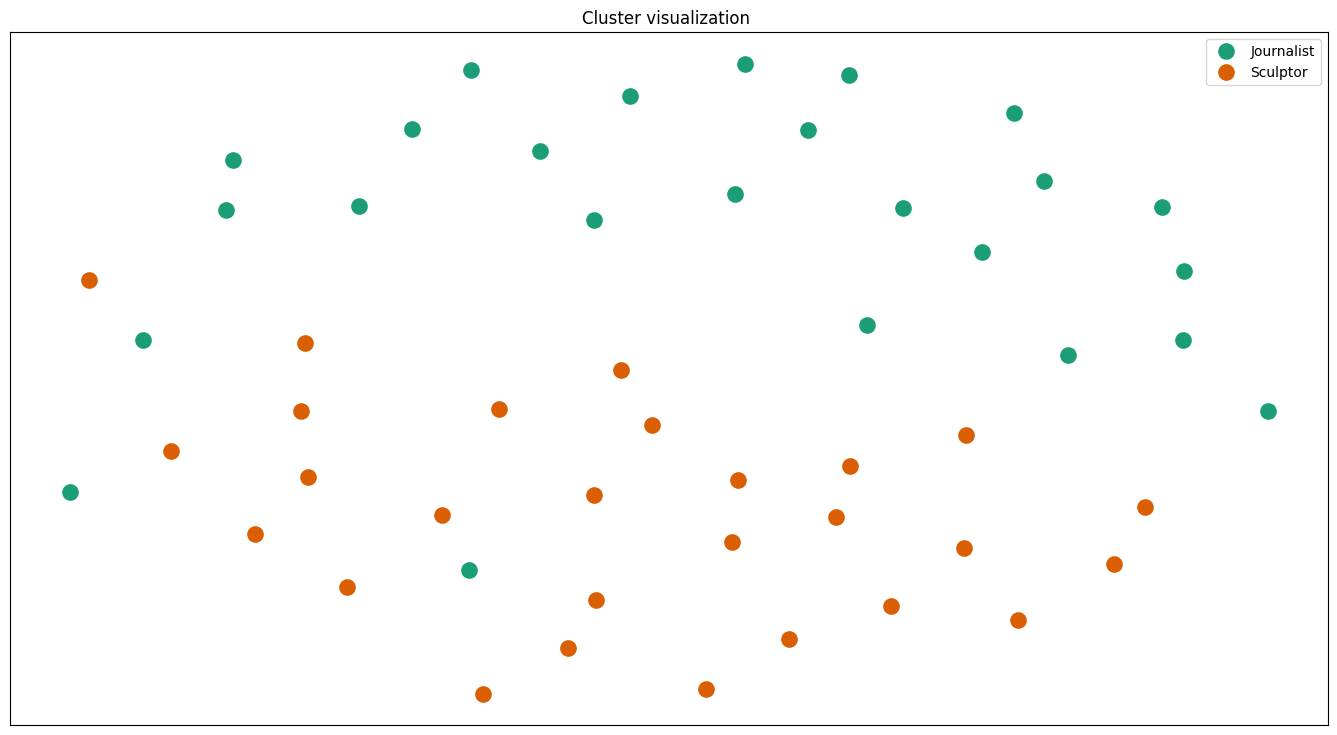

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

#dist_train = 1 - cosine_similarity(X_train_tfidf)
dist_test = 1 - cosine_similarity(X_test_tfidf)

# Use multidimensional scaling to convert the dist matrix into a 2-dimensional array
MDS()

# n_components=2 to plot results in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#pos_train = mds.fit_transform(dist_train)
pos_test = mds.fit_transform(dist_test)
#xs_train, ys_train = pos_train[:, 0], pos_train[:, 1]
xs_test, ys_test = pos_test[:, 0], pos_test[:, 1]

#set up colors per clusters
cluster_colors = {0: '#1b9e77', 1: '#d95f02'}

#set up cluster names
#cluster_names = {0: 'Other', 1: 'Chemistry', 2: 'Physics'}
cluster_names = {0: 'Journalist', 1: 'Sculptor'}

#create data frame that has the result of the MDS plus the cluster numbers and titles
#df_train = pd.DataFrame(dict(x=xs_train, y=ys_train, label=km.labels_))
df_test = pd.DataFrame(dict(x=xs_test, y=ys_test, label=clusters_test))

#group by cluster
groups = df_test.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_names[name],
            color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',
        which='both',
        left=False,
        top=False,
        labelleft=False)

ax.legend(numpoints=1)
plt.title('Cluster visualization ')
plt.show()

## MAIN #####################################################################################

In [ ]:
def main():
    print(createBiographyDataFrames())
    #print('hello')
    

In [ ]:
if __name__=='__main__':
    main()